In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import random
import os
import gc

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models, Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

In [2]:
train_dir = "C:/Users/Dell/Downloads/train"
test_dir = "C:/Users/Dell/Downloads/test"

In [3]:
train_non_autistic = []
train_autistic = []
for i in os.listdir(train_dir):
    if 'Non_Autistic' in ("C:/Users/Dell/Downloads/train/{}".format(i)):
        train_non_autistic.append(("C:/Users/Dell/Downloads/train/{}".format(i)))
    else:
        train_autistic.append(("C:/Users/Dell/Downloads/train/{}".format(i)))
        
test_imgs = ["C:/Users/Dell/Downloads/test/{}".format(i) for i in os.listdir(test_dir)]


train_imgs = train_autistic + train_non_autistic
random.shuffle(train_imgs)
os.listdir(train_dir)
del train_autistic
del train_non_autistic
gc.collect()

0

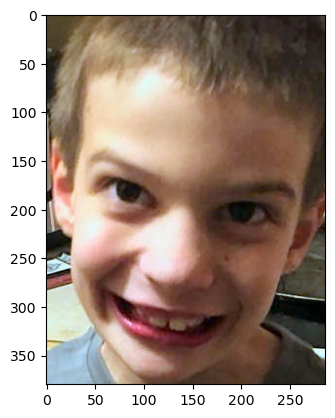

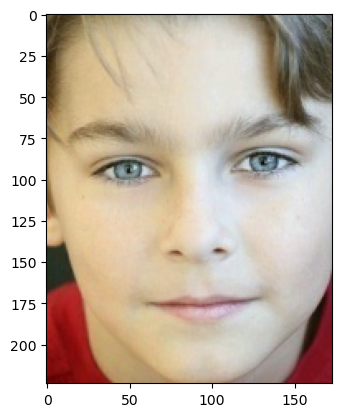

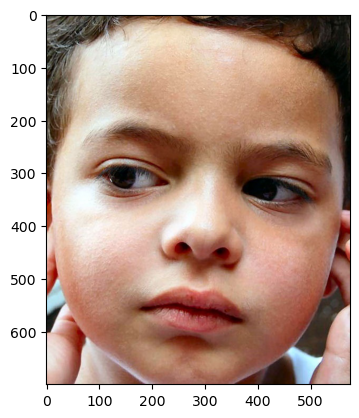

In [4]:
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img=mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

In [5]:
nrows = 150
ncolumns  = 150
channels = 3

def read_and_process_image(list_of_images):
    X = []
    y = []
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation = cv2.INTER_CUBIC))
        if "Non_Autistic" in image:
            y.append(0)
        else:
            y.append(1)
    #print(y)
    return X,y

In [6]:
X_train, y_train = read_and_process_image(train_imgs)

del train_imgs
gc.collect()

6155

[1 0 1 ... 0 0 1]


Text(0.5, 1.0, 'Train image labels')

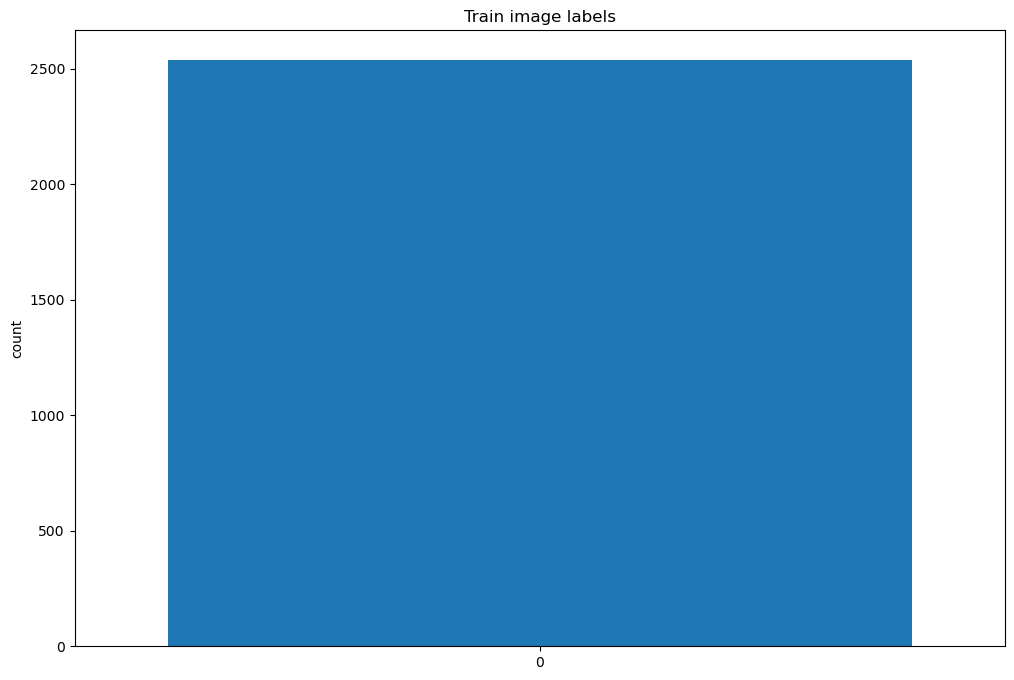

In [7]:
plt.figure(figsize=(12, 8))
X_train = np.array(X_train)
y_train = np.array(y_train)
print(y_train)
sns.countplot(y_train, saturation=1)
plt.title("Train image labels")

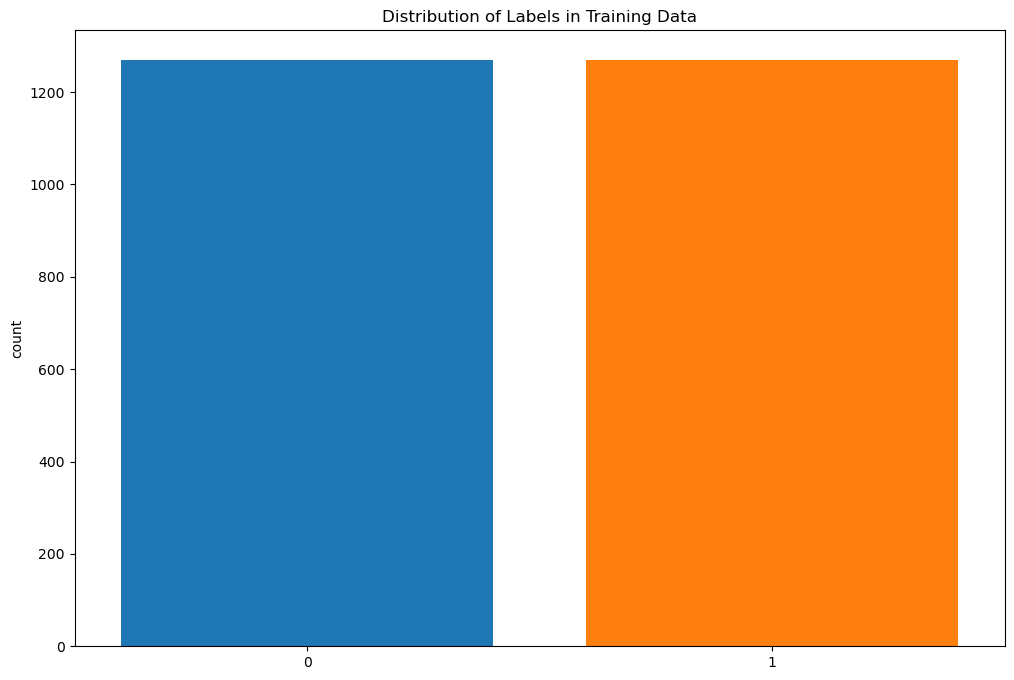

In [8]:
plt.figure(figsize=(12, 8))

sns.countplot(x=y_train, saturation=1)

plt.title("Distribution of Labels in Training Data")

plt.show()

In [9]:
import numpy as np

y_train = np.array(y_train)

print("Label counts:")
print(np.bincount(y_train))


Label counts:
[1270 1270]


In [10]:
print("Shape of train images:", X_train.shape)
print("Shape of train labels:", y_train.shape)

Shape of train images: (2540, 150, 150, 3)
Shape of train labels: (2540,)


In [11]:
val_autistic = "C:/Users/Dell/Downloads/valid/Autistic"
val_non_autistic = "C:/Users/Dell/Downloads/valid/Non_Autistic"
val_autistic_imgs = ["C:/Users/Dell/Downloads/valid/Autistic/{}".format(i) for i in os.listdir(val_autistic)]
val_non_autistic_imgs = ["C:/Users/Dell/Downloads/valid/Non_Autistic/{}".format(i) for i in os.listdir(val_non_autistic)]
val_imgs = val_autistic_imgs + val_non_autistic_imgs
random.shuffle(val_imgs)

del val_autistic_imgs
gc.collect()
del val_non_autistic_imgs
gc.collect()

0

In [12]:
X_val, y_val = read_and_process_image(val_imgs)

del val_imgs
gc.collect()

0

Text(0.5, 1.0, 'Validation image labels')

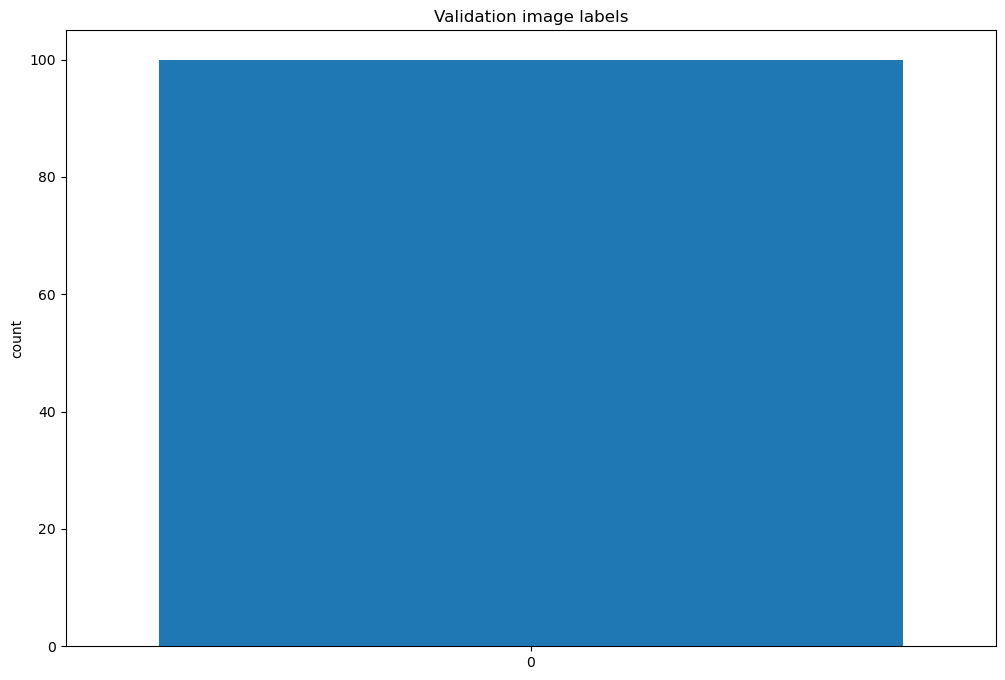

In [13]:
plt.figure(figsize=(12, 8))
X_val = np.array(X_val)
y_val = np.array(y_val)
sns.countplot(y_val, saturation=1)
plt.title("Validation image labels")

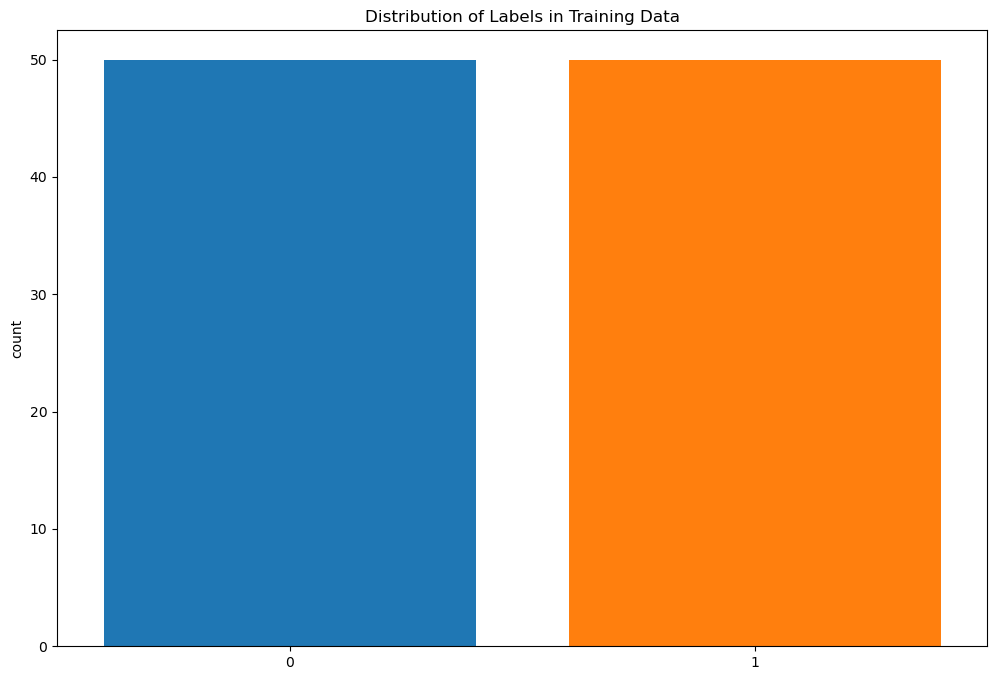

In [14]:
plt.figure(figsize=(12, 8))

sns.countplot(x=y_val, saturation=1)

plt.title("Distribution of Labels in Training Data")

plt.show()

In [15]:
print("Shape of validation images:", X_val.shape)
print("Shape of validation labels:", y_val.shape)

Shape of validation images: (100, 150, 150, 3)
Shape of validation labels: (100,)


In [16]:
ntrain = len(X_train)
nval = len(X_val)
batch_size = 32

In [17]:
base_model = VGG16(include_top=False,weights='imagenet',input_shape=(150,150,3))

In [18]:
for layer in base_model.layers:
   layer.trainable = False

In [19]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [20]:
model = keras.models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 18910017 (72.14 MB)
Trainable params: 4195329 (16.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [22]:
model.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(), metrics = ['acc'])

In [23]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [24]:
train_generator = train_datagen.flow(X_train, y_train, batch_size = batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size = batch_size)

In [25]:
history = model.fit(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=9,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size
                             )

Epoch 1/9


79/79 [==============================] - 142s 2s/step - loss: 0.7539 - acc: 0.6583 - val_loss: 0.6756 - val_acc: 0.6250
Epoch 2/9
79/79 [==============================] - 211s 3s/step - loss: 0.5582 - acc: 0.7093 - val_loss: 0.5692 - val_acc: 0.6771
Epoch 3/9
79/79 [==============================] - 2553s 33s/step - loss: 0.5432 - acc: 0.7261 - val_loss: 0.5121 - val_acc: 0.7500
Epoch 4/9
79/79 [==============================] - 236s 3s/step - loss: 0.5477 - acc: 0.7229 - val_loss: 0.5600 - val_acc: 0.6875
Epoch 5/9
79/79 [==============================] - 231s 3s/step - loss: 0.5215 - acc: 0.7337 - val_loss: 0.5299 - val_acc: 0.7188
Epoch 6/9
79/79 [==============================] - 232s 3s/step - loss: 0.5247 - acc: 0.7368 - val_loss: 0.5212 - val_acc: 0.7604
Epoch 7/9
79/79 [==============================] - 236s 3s/step - loss: 0.5214 - acc: 0.7384 - val_loss: 0.5268 - val_acc: 0.7188
Epoch 8/9
79/79 [==============================] - 232s 3s/step - loss: 0.5131 - acc: 

In [26]:
history_df = pd.DataFrame(history.history)
history_df

loss       acc  val_loss   val_acc
0  0.753903  0.658293  0.675563  0.625000
1  0.558238  0.709330  0.569181  0.677083
2  0.543199  0.726077  0.512091  0.750000
3  0.547662  0.722887  0.559982  0.687500
4  0.521545  0.733652  0.529933  0.718750
5  0.524712  0.736842  0.521155  0.760417
6  0.521372  0.738437  0.526840  0.718750
7  0.513059  0.746412  0.476007  0.781250
8  0.517852  0.743620  0.522198  0.718750

Text(0.5, 1.0, 'Training and Validation Accuracy')

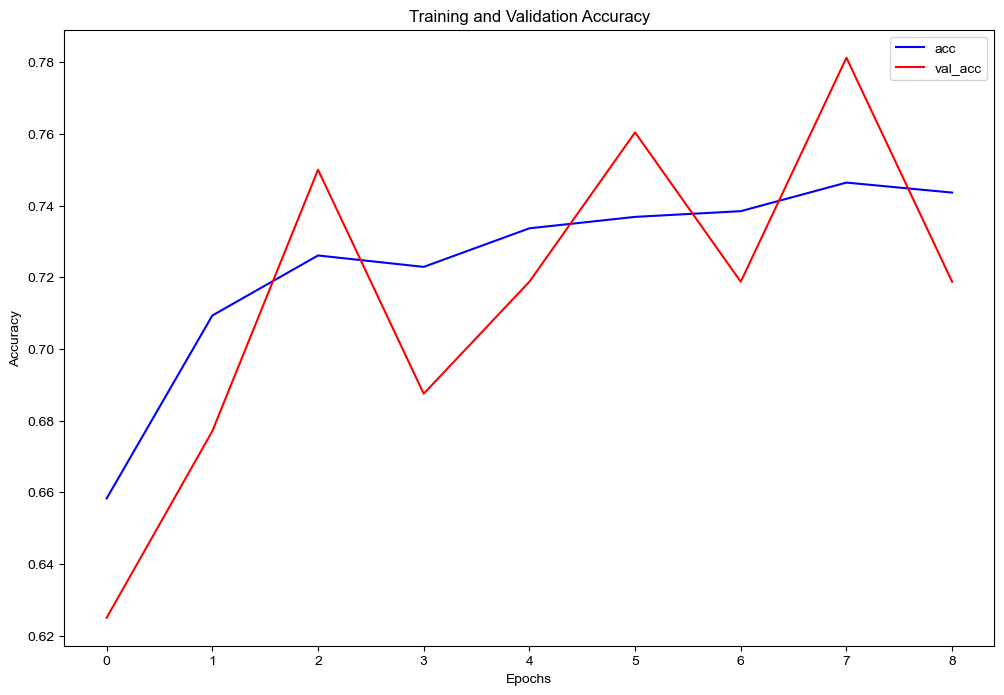

In [27]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["acc", "val_acc"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

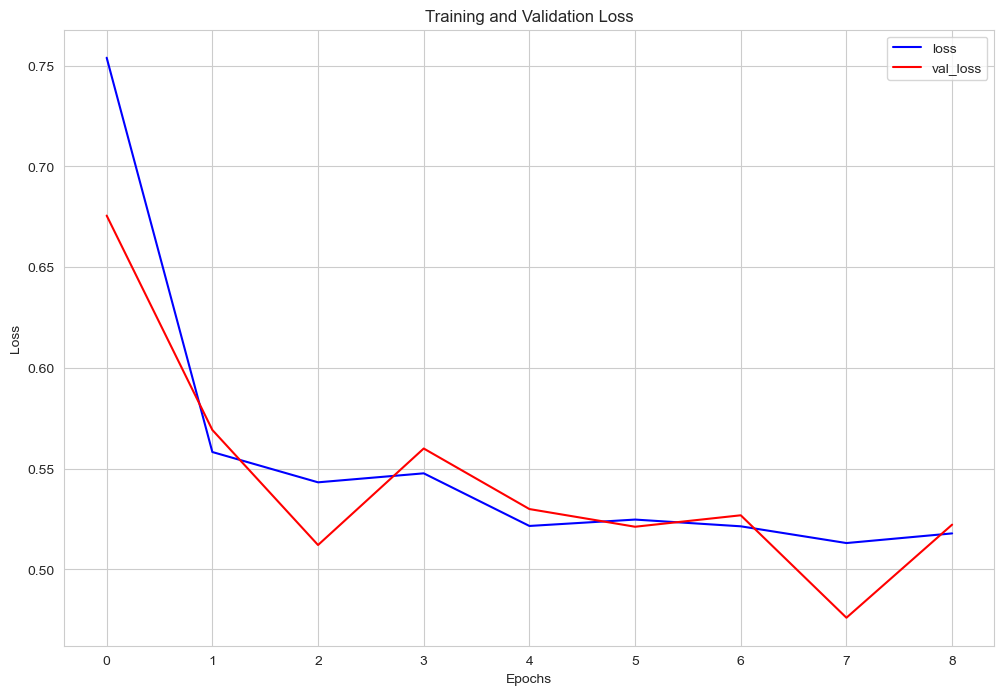

In [28]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["loss", "val_loss"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

In [29]:
random.shuffle(test_imgs)
X_test, y_test = read_and_process_image(test_imgs)
X = np.array(X_test)

In [30]:
pred = model.predict(X)
threshold = 0.5
predictions = np.where(pred > threshold, 1,0)

10/10 [==============================] - 27s 3s/step


In [31]:
test = pd.DataFrame(data = predictions, columns = ["predictions"])
test
test["filename"] = [os.path.basename(i) for i in test_imgs]
test["test_labels"] = y_test
test = test[["filename", "test_labels", "predictions"]]
test

filename  test_labels  predictions
0     Non_Autistic.32.jpg            0            0
1    Non_Autistic.119.jpg            0            0
2          Autistic.5.jpg            1            1
3    Non_Autistic.122.jpg            0            0
4         Autistic.20.jpg            1            1
..                    ...          ...          ...
295  Non_Autistic.114.jpg            0            0
296       Autistic.75.jpg            1            1
297      Autistic.127.jpg            1            1
298   Non_Autistic.24.jpg            0            1
299       Autistic.26.jpg            1            1

[300 rows x 3 columns]

<Axes: ylabel='count'>

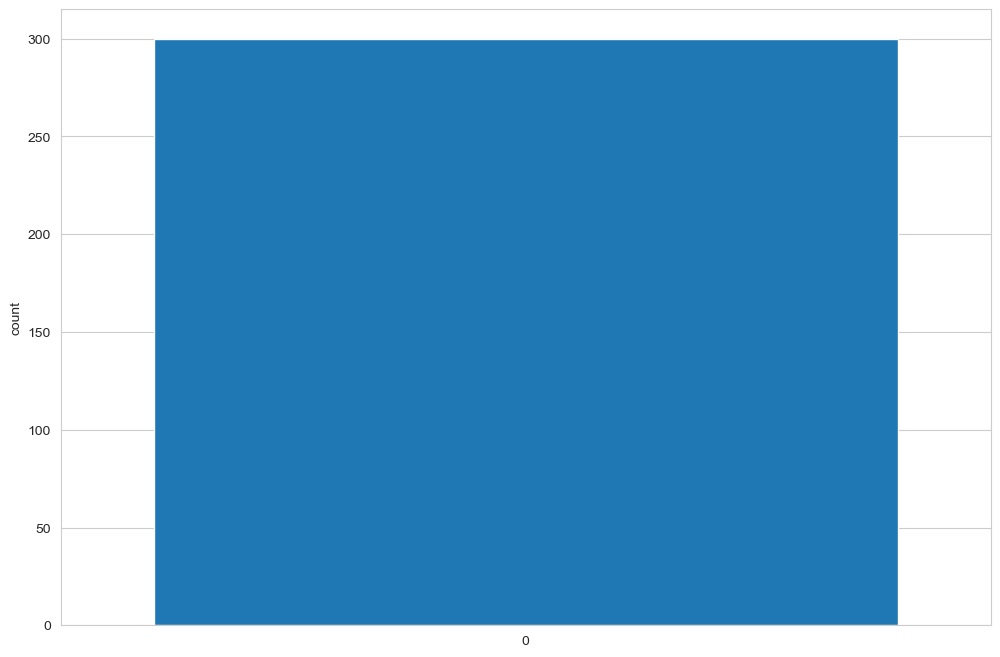

In [32]:
plt.figure(figsize=(12, 8))
sns.countplot(test["predictions"], saturation=1)

In [33]:
model_accuracy = accuracy_score(y_test, predictions)
print("Model Accuracy: {:.2f}%".format(model_accuracy * 100))

Model Accuracy: 73.67%


In [34]:
cl_report = classification_report(y_test, predictions)
print(cl_report)

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       150
           1       0.74      0.73      0.73       150

    accuracy                           0.74       300
   macro avg       0.74      0.74      0.74       300
weighted avg       0.74      0.74      0.74       300



In [35]:
cn_matrix= confusion_matrix(y_test, predictions)
cn_matrix

array([[112,  38],
       [ 41, 109]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix')

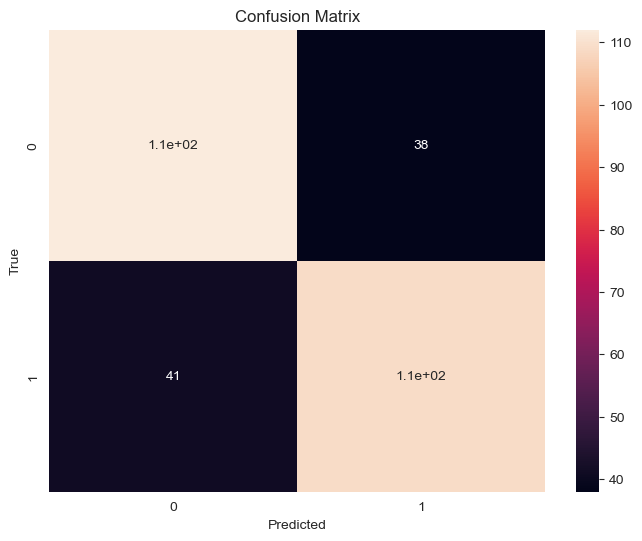

In [36]:
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

In [37]:
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc= auc(fpr, tpr)

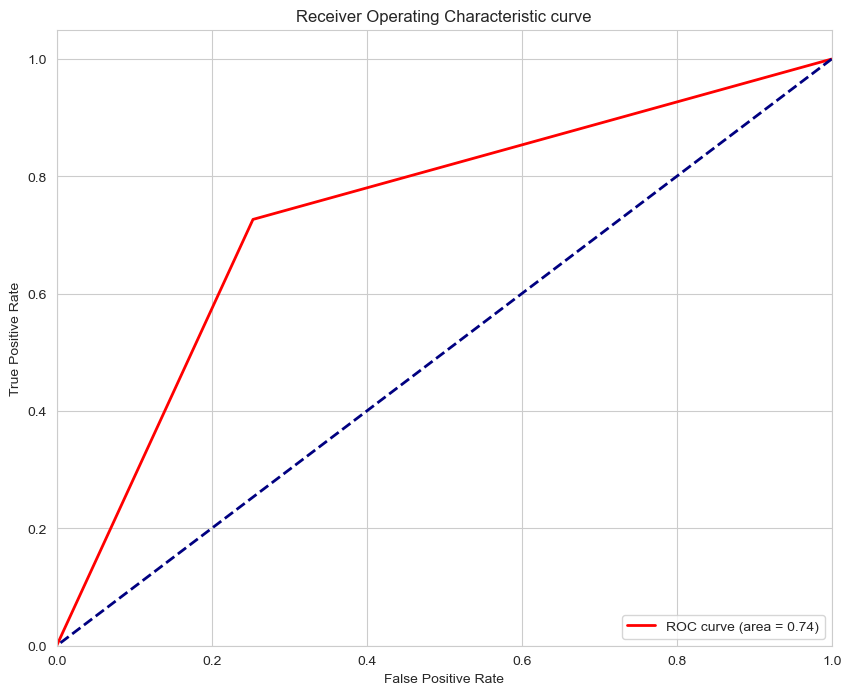

In [38]:
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, color = 'red', lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([1,0], [1,0], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiver Operating Characteristic curve")
plt.legend(loc = 'lower right')

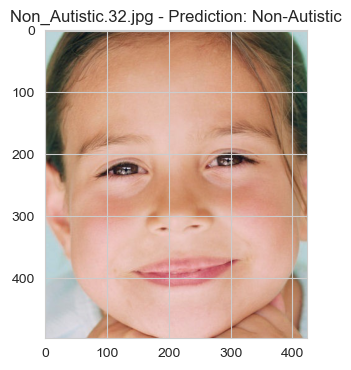

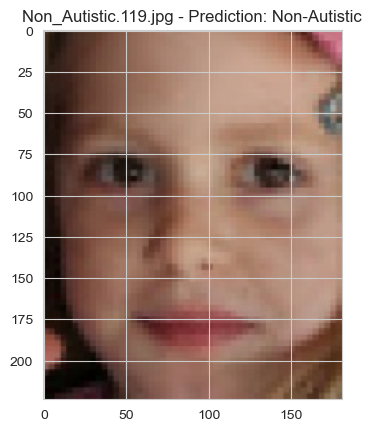

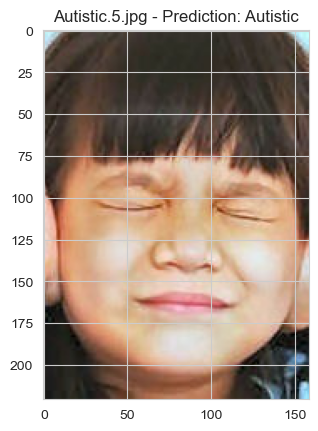

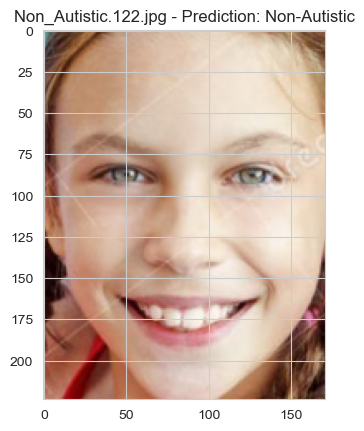

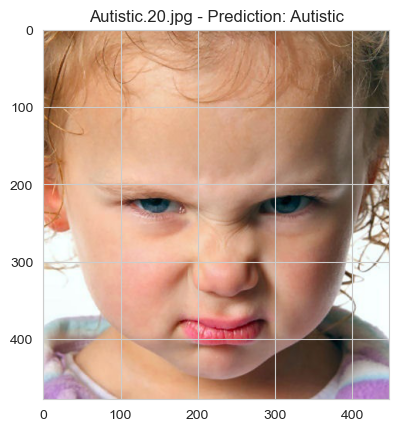

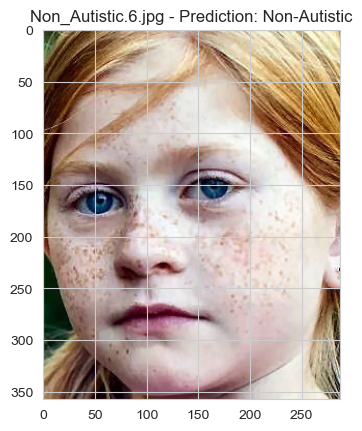

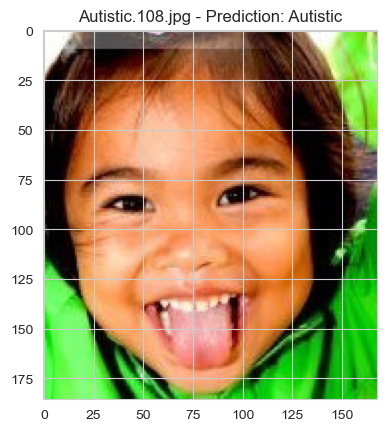

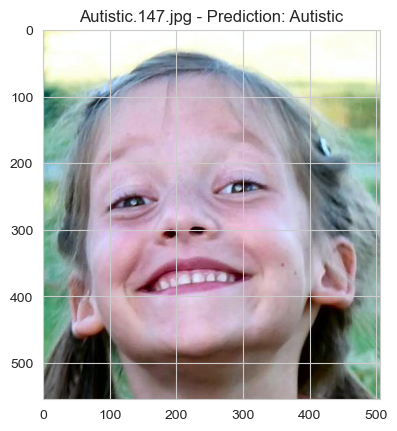

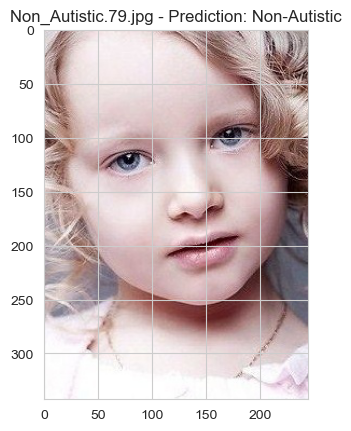

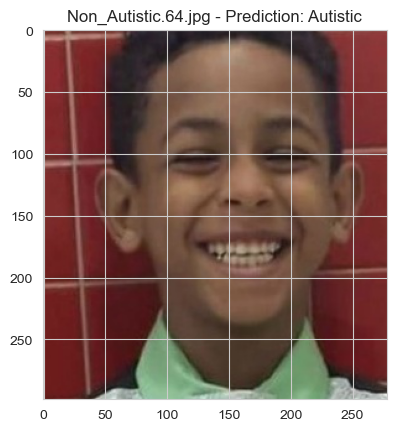

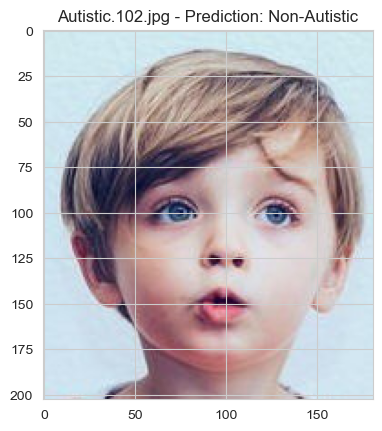

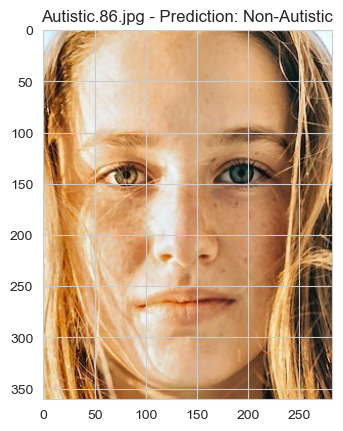

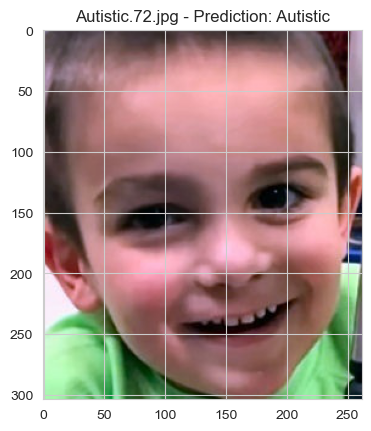

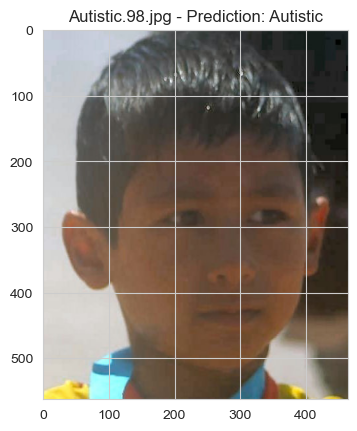

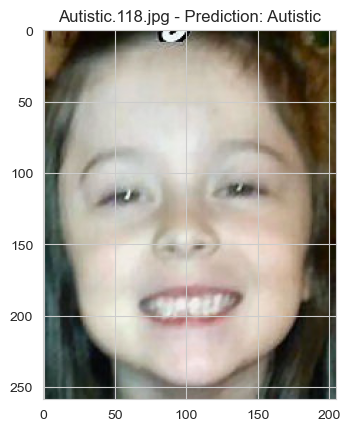

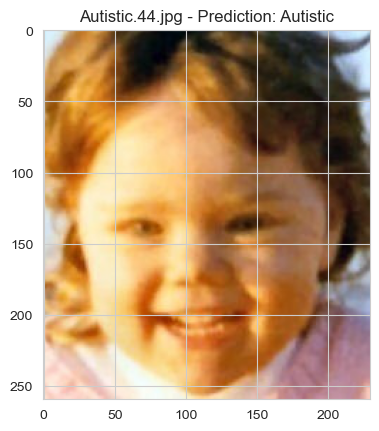

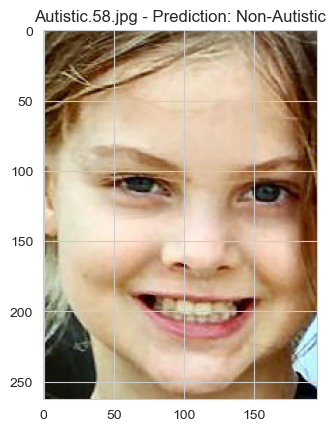

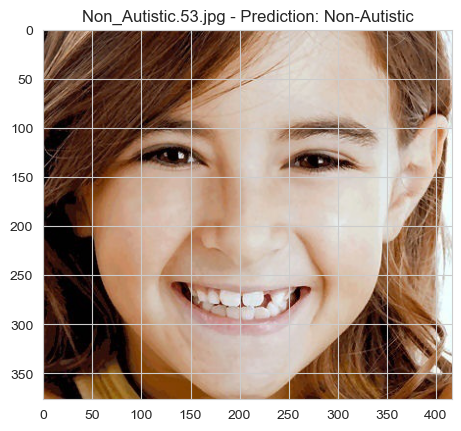

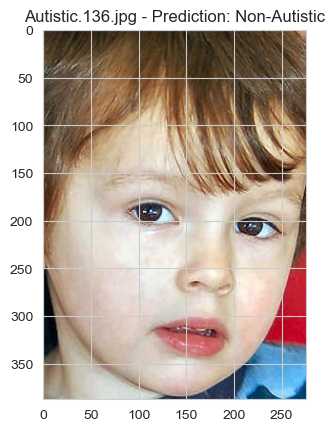

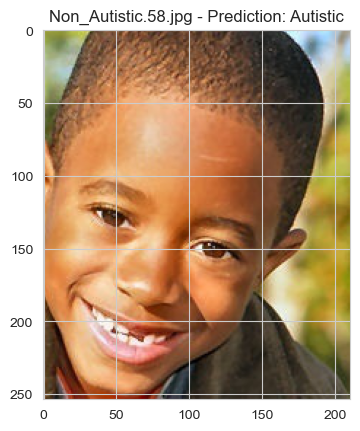

In [39]:
plt.figure(figsize=(4,4))
for val, i in enumerate(test_imgs[:20]):
    img = mpimg.imread(i)
    imgplot = plt.imshow(img)
    plt.title(os.path.basename(i) + ' - Prediction: ' +  f"{'Autistic' if predictions[val] == 1 else 'Non-Autistic'}")
    plt.show()